In [1]:
%matplotlib widget
import jungfrau_utils as ju
import numpy as np
import json, h5py
import os, glob
import time
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib import cm
from scipy.optimize import curve_fit
from IPython.display import clear_output, display
import matplotlib.colors as colors
import matplotlib.ticker as ticker
from ipyfilechooser import FileChooser
from scipy.stats.stats import pearsonr

from alvra_tools.load_data import *
from alvra_tools.channels import *
from alvra_tools.utils import *
from alvra_tools.XES_functions import *

import warnings
warnings.filterwarnings('ignore')

In [2]:
pgroup='p20222'
runlist = [790]
#runlist = np.arange(488,495,1)
print (runlist)

#############################################################
from itertools import chain
jsonlist = []
for run in runlist:
    file = glob('/sf/alvra/data/{}/raw/*{:04d}*/meta/scan.json'.format(pgroup, run))
    jsonlist.append(file)
jsonlist = itertools.chain.from_iterable(jsonlist)
jsonlist = sorted(jsonlist, key = os.path.getmtime)
jsonlist

[790]


['/sf/alvra/data/p20222/raw/run0790-FebpyCN4_DMA_7uJ_short_001/meta/scan.json']

In [3]:
roi1 = (5050, 5170, 135, 205) #signal CRY2 low
roi2 = (5050, 5170, 315, 365) #signan CRY2 up

roi3 = (8400, 8540, 155, 215) #signal CRY1 low
roi4 = (8400, 8540, 295, 345) #signal CRY1 up

threshold_low = 5
threshold_high = 50
nshots = None
nsteps = 2

correctFlag = (False,False,False,False)
binsize=5

Timezero_mm = 100.01392

#####################################################################################
from sfdata import SFScanInfo

for json in jsonlist:
    
    scan = SFScanInfo(json)
    try:
        Timezero_mm = get_timezero_NBS(json)
        flag = True
    except:
        Timezero_mm = Timezero_mm

    spectrum_roi1_ON, spectrum_roi2_ON, spectrum_roi3_ON, spectrum_roi4_ON, pids_on, \
    spectrum_roi1_OFF, spectrum_roi2_OFF, spectrum_roi3_OFF, spectrum_roi4_OFF, pids_off, Delay_fs, Delay_mm = \
    XES_delayscan_4ROIs_sfdata(scan, pgroup, roi1, roi2, roi3, roi4, threshold_low, threshold_high, nshots, correctFlag, binsize, nsteps=nsteps)

    print ('------------------------------')
    if flag:
        print ('Timezero found in file = {} mm'.format(Timezero_mm))
    else:
        print ('Timezero = {} mm'.format(Timezero_mm))

    if scan.parameters['units'] == ['nS']:
        Delay_fs = - scan.values
    #    Delay_fs = Delay_fs - 0.17
    else:
        Delay_fs = scan.values
        Delay_fs = Delay_fs - mm2fs(Timezero_mm, 0)
        
    run_name = json.split('/')[-3]
    reducedir = '/das/work/p20/p20263/Claudio/Reduced/'
    os.makedirs(reducedir+run_name, exist_ok=True)

    np.save(reducedir+run_name+'/delays_fs.npy', Delay_fs)
    np.save(reducedir+run_name+'/delays_mm.npy', Delay_mm)

    for i, spectrum in enumerate([spectrum_roi1_ON, spectrum_roi2_ON, spectrum_roi3_ON, spectrum_roi4_ON]):
        np.save(reducedir+run_name+'/spectrum_roi{}_ON.npy'.format(i+1), spectrum)

    for i, spectrum in enumerate([spectrum_roi1_OFF, spectrum_roi2_OFF, spectrum_roi3_OFF, spectrum_roi4_OFF]):
        np.save(reducedir+run_name+'/spectrum_roi{}_OFF.npy'.format(i+1), spectrum)


    print ('Processed run {}'.format(json.split('/')[-3]))

It took 22.34 seconds to process this file

Job done! It took 43.41 seconds to process 2 file(s)
------------------------------
Timezero found in file = 118.00592000004498 mm
Processed run run0790-FebpyCN4_DMA_7uJ_short_001


In [4]:
np.shape(spectrum_roi1_ON)

(2, 120)

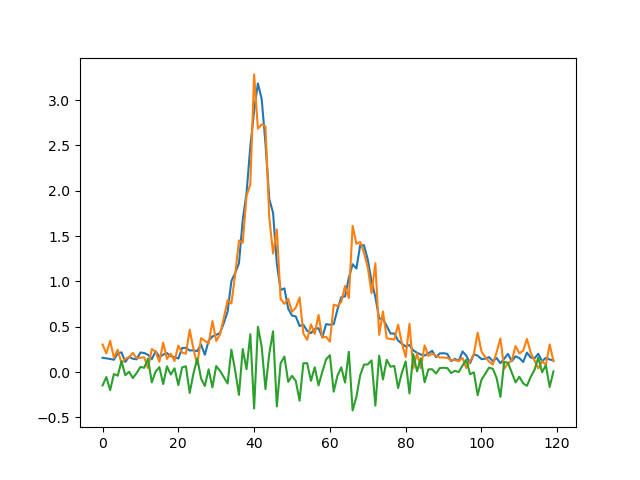

In [9]:
plt.figure()
plt.plot(spectrum_roi1_ON[0])# - np.average(spectrum_roi1_OFF[0]))
plt.plot(spectrum_roi1_OFF[0])# - np.average(spectrum_roi1_OFF[0]))
plt.plot(spectrum_roi1_ON[0] - spectrum_roi1_OFF[0])

plt.show()

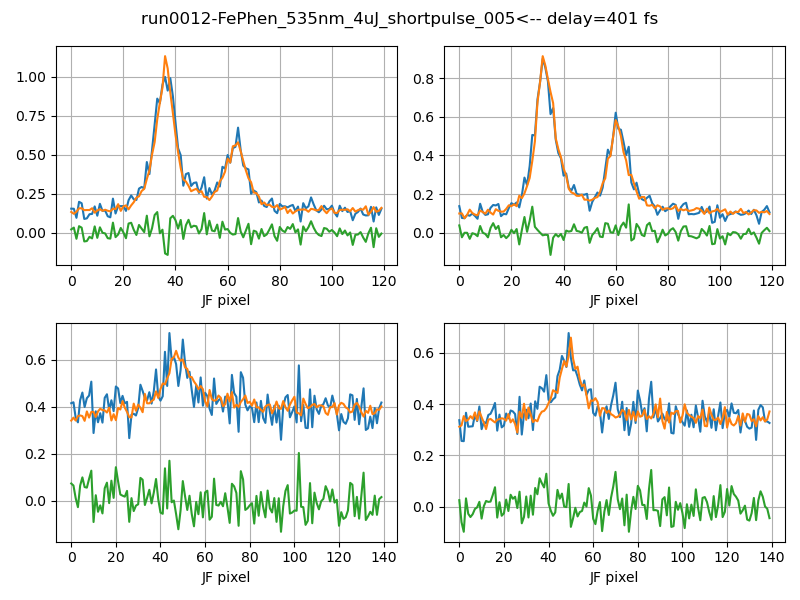

In [11]:
index2plot = 15

#############################################3

specON_array = [spectrum_roi1_ON, spectrum_roi2_ON, spectrum_roi3_ON, spectrum_roi4_ON]
specOFF_array = [spectrum_roi1_OFF, spectrum_roi2_OFF, spectrum_roi3_OFF, spectrum_roi4_OFF]

fig = plt.figure(figsize=(8, 6))
plt.suptitle(run_name+ '<-- delay={:.0f} fs'.format(Delay_fs[index2plot]))

for i in range(4):
    location = 221+i  # this is to index the position of the subplot
    ax = plt.subplot(location)
    ax.plot(specON_array[i][index2plot])
    ax.plot(np.average(specOFF_array[i],axis=0))
    ax.plot(specON_array[i][index2plot]-np.average(specOFF_array[i], axis=0))
    plt.grid()
    plt.xlabel('JF pixel')

plt.tight_layout()

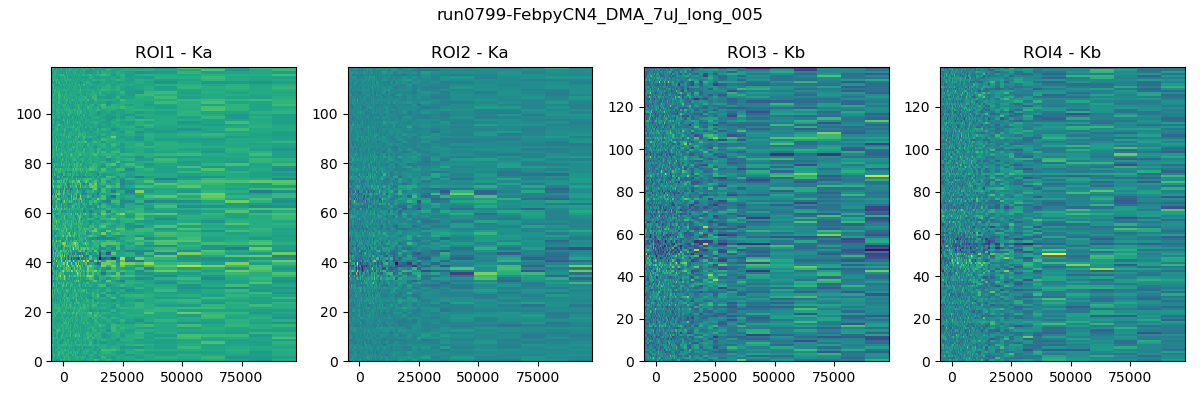

In [184]:
xaxis12 = np.arange(0,np.shape(spectrum_roi1_ON)[1])
xaxis34 = np.arange(0,np.shape(spectrum_roi3_ON)[1])

plt.figure(figsize=(12,4))
plt.suptitle(run_name)
plt.subplot(141)
plt.title('ROI1 - Ka')
plt.pcolormesh(Delay_fs, xaxis12, np.transpose(spectrum_roi1_ON-np.average(spectrum_roi1_OFF,axis=0)))

plt.subplot(142)
plt.title('ROI2 - Ka')
plt.pcolormesh(Delay_fs, xaxis12, np.transpose(spectrum_roi2_ON-np.average(spectrum_roi2_OFF,axis=0)))

plt.subplot(143)
plt.title('ROI3 - Kb')
plt.pcolormesh(Delay_fs, xaxis34, np.transpose(spectrum_roi3_ON-np.average(spectrum_roi3_OFF,axis=0)))

plt.subplot(144)
plt.title('ROI4 - Kb')
plt.pcolormesh(Delay_fs, xaxis34, np.transpose(spectrum_roi4_ON-np.average(spectrum_roi4_OFF,axis=0)))

plt.tight_layout()
plt.show()

(120, 83)


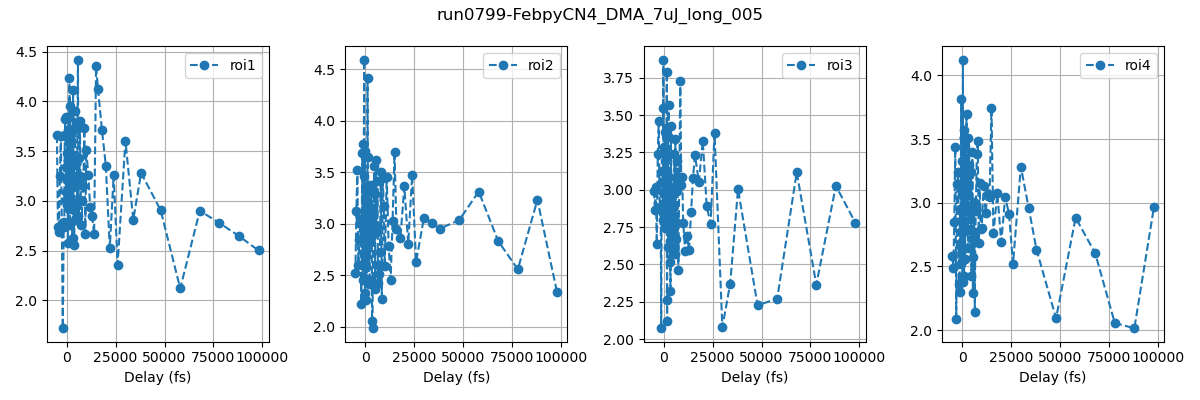

In [191]:
plt.figure(figsize=(12,4))
plt.suptitle(run_name)

plt.subplot(141)
map_2D = np.transpose(spectrum_roi1_ON-np.average(spectrum_roi1_OFF,axis=0))
print (np.shape(map_2D))
plt.plot(Delay_fs, np.sum(np.abs(map_2D[35:65,:]), axis = 0), '--o', label='roi1')
plt.grid()
plt.legend(loc='best')
plt.xlabel('Delay (fs)')

plt.subplot(142)
map_2D = np.transpose(spectrum_roi2_ON-np.average(spectrum_roi2_OFF,axis=0))
plt.plot(Delay_fs, np.sum(np.abs(map_2D[35:65,:]), axis = 0), '--o', label='roi2')
plt.grid()
plt.legend(loc='best')
plt.xlabel('Delay (fs)')


plt.subplot(143)
map_2D = np.transpose(spectrum_roi3_ON-np.average(spectrum_roi3_OFF,axis=0))
plt.plot(Delay_fs, np.sum(np.abs(map_2D[35:65,:]), axis = 0), '--o', label='roi3')
plt.legend(loc='best')
plt.grid()
plt.xlabel('Delay (fs)')

plt.subplot(144)
map_2D = np.transpose(spectrum_roi4_ON-np.average(spectrum_roi4_OFF,axis=0))
plt.plot(Delay_fs, np.sum(np.abs(map_2D[35:65,:]), axis = 0), '--o', label='roi4')
plt.legend(loc='best')
plt.grid()
plt.xlabel('Delay (fs)')
plt.tight_layout()
plt.show()

## Combining identical scans

In [32]:
files = ['/sf/alvra/data/p20222/raw/run{:04d}-FebpyCN4_H20_4uJ_mixGain_short_{:03d}/meta/scan.json'.format(322+i, 1+i) for i in range(8)]
files

['/sf/alvra/data/p20222/raw/run0322-FebpyCN4_H20_4uJ_mixGain_short_001/meta/scan.json',
 '/sf/alvra/data/p20222/raw/run0323-FebpyCN4_H20_4uJ_mixGain_short_002/meta/scan.json',
 '/sf/alvra/data/p20222/raw/run0324-FebpyCN4_H20_4uJ_mixGain_short_003/meta/scan.json',
 '/sf/alvra/data/p20222/raw/run0325-FebpyCN4_H20_4uJ_mixGain_short_004/meta/scan.json',
 '/sf/alvra/data/p20222/raw/run0326-FebpyCN4_H20_4uJ_mixGain_short_005/meta/scan.json',
 '/sf/alvra/data/p20222/raw/run0327-FebpyCN4_H20_4uJ_mixGain_short_006/meta/scan.json',
 '/sf/alvra/data/p20222/raw/run0328-FebpyCN4_H20_4uJ_mixGain_short_007/meta/scan.json',
 '/sf/alvra/data/p20222/raw/run0329-FebpyCN4_H20_4uJ_mixGain_short_008/meta/scan.json']

In [35]:
pgroup = 'p20222'

roi1 = (5050, 5170, 135, 205) #signal CRY2 low
roi2 = (5050, 5170, 315, 365) #signal CRY2 up

roi3 = (8400, 8540, 155, 215) #signal CRY1 low
roi4 = (8400, 8540, 295, 345) #signal CRY1 up

threshold_low = 3
threshold_high = 50
nshots = 1000
nsteps = None

correctFlag = (False,False,False,False)
binsize = 5

Timezero_mm = 100.01392

#####################################################################################
from sfdata import SFScanInfo

roi1_all_on = []
roi2_all_on = []
roi3_all_on = []
roi4_all_on = []

roi1_all_off = []
roi2_all_off = []
roi3_all_off = []
roi4_all_off = []

for num, file in enumerate(files):
    scan = SFScanInfo(file)
    print(f'Processing scan {num+1} of {len(files)}...')
    try:
        Timezero_mm = get_timezero_NBS(file)
        flag = True
    except:
        Timezero_mm = Timezero_mm

    spectrum_roi1_ON, spectrum_roi2_ON, spectrum_roi3_ON, spectrum_roi4_ON, pids_on, \
    spectrum_roi1_OFF, spectrum_roi2_OFF, spectrum_roi3_OFF, spectrum_roi4_OFF, pids_off, Delay_fs, Delay_mm = \
    XES_delayscan_4ROIs(scan, pgroup, roi1, roi2, roi3, roi4, threshold_low, threshold_high, nshots, correctFlag, binsize, nsteps=nsteps)
    
    roi1_all_on.append(spectrum_roi1_ON)
    roi2_all_on.append(spectrum_roi2_ON)
    roi3_all_on.append(spectrum_roi3_ON)
    roi4_all_on.append(spectrum_roi4_ON)

    roi1_all_off.append(spectrum_roi1_OFF)
    roi2_all_off.append(spectrum_roi2_OFF)
    roi3_all_off.append(spectrum_roi3_OFF)
    roi4_all_off.append(spectrum_roi4_OFF)
    
    print ('------------------------------')
    if flag:
        print ('Timezero found in file = {} mm'.format(Timezero_mm))
    else:
        print ('Timezero = {} mm'.format(Timezero_mm))

    if scan.parameters['units'] == ['nS']:
        Delay_fs = - scan.values
    else:
        Delay_fs = scan.values
        Delay_fs = Delay_fs - mm2fs(Timezero_mm, 0)

roi1_all_on = np.array(roi1_all_on)
roi2_all_on = np.array(roi2_all_on)
roi3_all_on = np.array(roi3_all_on)
roi4_all_on = np.array(roi4_all_on)

roi1_all_off = np.array(roi1_all_off)
roi2_all_off = np.array(roi2_all_off)
roi3_all_off = np.array(roi3_all_off)
roi4_all_off = np.array(roi4_all_off)
 

It took 7.18 seconds to process this file

Job done! It took 13.14 seconds to process 2 file(s)
------------------------------
Timezero found in file = 100.01392000004499 mm


In [70]:
np.shape(roi[1][idx])

(31, 140)

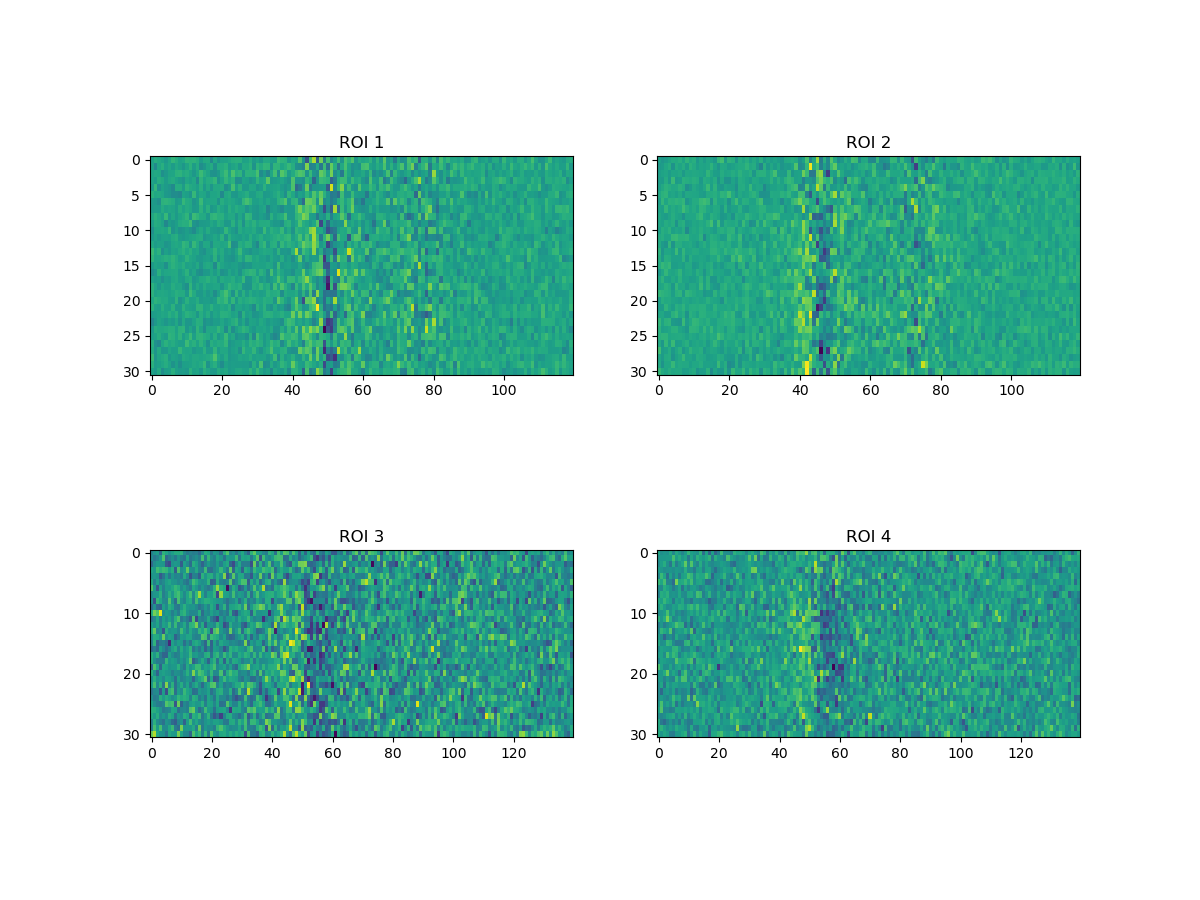

In [79]:
rois = [(roi1_all_on, roi1_all_off), (roi2_all_on, roi2_all_off),
        (roi3_all_on, roi3_all_off), (roi4_all_on, roi4_all_off)]

idx = [0,1,2,4,5,6]

fig = plt.figure(figsize=(12,9))

for num, roi in enumerate(rois):
    ax = fig.add_subplot(2,2,num+1)
    ax.imshow(np.average(roi[0][idx], axis=0) - np.average(roi[1][idx],axis=0), aspect=2)
    ax.set_title(f'ROI {num+1}')

plt.show()

In [14]:
datafiles = []
for file in glob.glob('/sf/alvra/data/p18938/raw/scan_info/Febpy_XES_timescan_NOPA*'):
    datafiles.append(file)
datafiles = sorted(datafiles, key = os.path.getmtime)
patch = datafiles[24:30]
patch

['/sf/alvra/data/p18938/raw/scan_info/Febpy_XES_timescan_NOPA_loop_23.json',
 '/sf/alvra/data/p18938/raw/scan_info/Febpy_XES_timescan_NOPA_loop_24.json',
 '/sf/alvra/data/p18938/raw/scan_info/Febpy_XES_timescan_NOPA_loop_25.json',
 '/sf/alvra/data/p18938/raw/scan_info/Febpy_XES_timescan_NOPA_loop_26.json',
 '/sf/alvra/data/p18938/raw/scan_info/Febpy_XES_timescan_NOPA_loop_27.json',
 '/sf/alvra/data/p18938/raw/scan_info/Febpy_XES_timescan_NOPA_loop_28.json']

In [15]:
roi1 = (7740, 7900, 220, 300) #signal 1
roi2 = (7740, 7900, 400, 480) #bkg 1

roi3 = (5080, 5220, 180, 280) #signal 2
roi4 = (5080, 5220, 300, 400) #bkg 2

threshold_low = 5
#threshold_high = 10

######################################################################################
outdir = '/sf/alvra/data/p18938/res/Claudio/'

XAS_total_roi1 = 0
XAS_total_roi3 = 0

clock2 = Clock()

for json_file in patch:
    XAS_roi1 = []
    XAS_roi1_on = []
    #Error_XAS_roi1 = []
    XAS_roi3 = []
    XAS_roi3_on = []
    #Error_XAS_roi3 = []
        
    RIXS_transient_roi1 = []
    RIXS_transient_roi3 = []
    Error_transient_roi1 = []
    Error_transient_roi3 = []
    RIXS_unpumped_roi1 = []
    RIXS_unpumped_roi3 = []
    Error_unpumped_roi1 = []
    Error_unpumped_roi3 = []
    RIXS_pumped_roi1 = []
    RIXS_pumped_roi3 = []
    Error_pumped_roi1 = []
    Error_pumped_roi3 = []
    XAS_transient_roi1 =[]
    XES_transient_roi1 =[]
    XAS_transient_roi3 =[]
    XES_transient_roi3 =[]
        
    XES_abs_roi1 = []
    XES_abs_roi3 = []

    scan_data = load_scan_data(json_file)

    Energy_eV = []
    Delay_mm = load_scan_readback(json_file)
    
    #XES_1D = []
    
    clock1 = Clock()
    
    num_scan_files = len(scan_data)
    print('json file is {}'.format(json_file))
    print("\nProcessing", num_scan_files, "total files")
    
    for i, (pv, bs, fn) in enumerate(scan_data):
    #for i in range(0,4):
        print("\n File {} out of {}: Processing {}".format(i+1, num_scan_files, fn.split('/')[-2:]))
        
        spectrum_ON_roi1 = 0
        spectrum_ON_roi2 = 0
        spectrum_ON_roi3 = 0
        spectrum_ON_roi4 = 0
        spectrum_OFF_roi1 = 0
        spectrum_OFF_roi2 = 0
        spectrum_OFF_roi3 = 0
        spectrum_OFF_roi4 = 0
        
        nshots = None  # put this to None for ALL images
        #nshots = None
        
        
        images_pump_roi1, images_pump_roi2, images_pump_roi3, images_pump_roi4, pids_ON, \
        images_unpump_roi1, images_unpump_roi2, images_unpump_roi3, images_unpump_roi4, pids_OFF = \
        load_crop_JF_batches_on_off_4rois(fn, roi1, roi2, roi3, roi4, 50, 25, nshots=nshots)
        
    #   images_ON_roi1, images_ON_roi2, pids_ON, images_OFF_roi1, images_OFF_roi2, pids_OFF = \
    #   load_crop_JF_data_on_off(fn, roi1, roi2, 50, 25, pedestal_file=pedestal_file, nshots=nshots)
        
    #    energy, pids = load_single_channel_pulseID(bs, channel_energy, 50)
    #    energy = [x for x in energy if (x > 0)]
    #    Energy_eV.append(np.mean(energy))
        
    #    delay, pids = load_single_channel_pulseID(bs, channel_delay_harm, 50)
    #    delay = [x for x in delay if (x > 0)]
    #    Delay_mm.append(np.mean(delay))
    
        images_pump_roi1_thr = images_pump_roi1.copy()
        images_pump_roi1_thr[images_pump_roi1 < threshold_low] = 0
        #images_pump_roi1_thr[images_pump_roi1 > threshold_high] = 0
        images_unpump_roi1_thr = images_unpump_roi1.copy()
        images_unpump_roi1_thr[images_unpump_roi1 < threshold_low] = 0
        #images_unpump_roi1_thr[images_unpump_roi1 > threshold_high] = 0
        
        images_pump_roi2_thr = images_pump_roi2.copy()
        images_pump_roi2_thr[images_pump_roi2 < threshold_low] = 0
        #images_pump_roi2_thr[images_pump_roi2 > threshold_high] = 0
        images_unpump_roi2_thr = images_unpump_roi2.copy()
        images_unpump_roi2_thr[images_unpump_roi2 < threshold_low] = 0
        #images_unpump_roi2_thr[images_unpump_roi2 > threshold_high] = 0
        
        images_pump_roi3_thr = images_pump_roi3.copy()
        images_pump_roi3_thr[images_pump_roi3 < threshold_low] = 0
        #images_pump_roi3_thr[images_pump_roi3 > threshold_high] = 0
        images_unpump_roi3_thr = images_unpump_roi3.copy()
        images_unpump_roi3_thr[images_unpump_roi3 < threshold_low] = 0
        #images_unpump_roi3_thr[images_unpump_roi3 > threshold_high] = 0
        
        images_pump_roi4_thr = images_pump_roi4.copy()
        images_pump_roi4_thr[images_pump_roi4 < threshold_low] = 0
        #images_pump_roi4_thr[images_pump_roi4 > threshold_high] = 0
        images_unpump_roi4_thr = images_unpump_roi4.copy()
        images_unpump_roi4_thr[images_unpump_roi4 < threshold_low] = 0
        #images_unpump_roi4_thr[images_unpump_roi4 > threshold_high] = 0
        
        spectrum_ON_roi1 = images_pump_roi1_thr.sum(axis = 1).sum(axis = 0)
        spectrum_OFF_roi1 = images_unpump_roi1_thr.sum(axis = 1).sum(axis = 0)
        spectrum_ON_roi2 = images_pump_roi2_thr.sum(axis = 1).sum(axis = 0)
        spectrum_OFF_roi2 = images_unpump_roi2_thr.sum(axis = 1).sum(axis = 0)
        spectrum_ON_roi3 = images_pump_roi3_thr.sum(axis = 1).sum(axis = 0)
        spectrum_OFF_roi3 = images_unpump_roi3_thr.sum(axis = 1).sum(axis = 0)
        spectrum_ON_roi4 = images_pump_roi4_thr.sum(axis = 1).sum(axis = 0)
        spectrum_OFF_roi4 = images_unpump_roi4_thr.sum(axis = 1).sum(axis = 0)
    
    ######################### ROI 1 & 2 ##############################################
        
        XAS_roi1.append(np.abs(spectrum_OFF_roi1.sum() - spectrum_OFF_roi2.sum()))
        XAS_roi1_on.append(np.abs(spectrum_ON_roi1.sum() - spectrum_ON_roi2.sum()))
        RIXS_unpumped_roi1.append(spectrum_OFF_roi1 - spectrum_OFF_roi2)
     #   Error_unpumped_roi1.append(np.sqrt(spectrum_OFF_roi1))
        RIXS_pumped_roi1.append(spectrum_ON_roi1 - spectrum_ON_roi2)
     #   Error_pumped_roi1.append(np.sqrt(spectrum_ON_roi1))
    
        XES_transient_roi1 = (spectrum_ON_roi1 - spectrum_ON_roi2) - (spectrum_OFF_roi1 - spectrum_OFF_roi2)
        
        RIXS_transient_roi1.append(XES_transient_roi1)
     #   Error_transient_roi1.append(np.sqrt((np.sqrt(spectrum_ON_roi1))**2 + (np.sqrt(spectrum_OFF_roi1))**2))
      
        XES_abs_roi1 = np.abs(XES_transient_roi1)
        
     #   XES_1D.append(np.sum(XES_transient_roi1, axis = 1))
        
        XAS_transient_roi1.append(np.sum(XES_abs_roi1[50:80]))
        
    ######################### ROI 3 & 4 ##############################################
        
        XAS_roi3.append(np.abs(spectrum_OFF_roi3.sum() - spectrum_OFF_roi4.sum()))
        XAS_roi3_on.append(np.abs(spectrum_ON_roi3.sum() - spectrum_ON_roi4.sum()))
        RIXS_unpumped_roi3.append(spectrum_OFF_roi3 - spectrum_OFF_roi4)
     #   Error_unpumped_roi3.append(np.sqrt(spectrum_OFF_roi3))
        RIXS_pumped_roi3.append(spectrum_ON_roi3 - spectrum_ON_roi4)
     #   Error_pumped_roi3.append(np.sqrt(spectrum_ON_roi3))
    
        XES_transient_roi3 = (spectrum_ON_roi3 - spectrum_ON_roi4) - (spectrum_OFF_roi3 - spectrum_OFF_roi4)
        
        RIXS_transient_roi3.append(XES_transient_roi3)
     #   Error_transient_roi3.append(np.sqrt((np.sqrt(spectrum_ON_roi1))**2 + (np.sqrt(spectrum_OFF_roi1))**2))
        
        XES_abs_roi3 = np.abs(XES_transient_roi3)
     #   XES_1D.append(np.sum(XES_transient_roi3, axis = 1))
        
        XAS_transient_roi3.append(np.sum(XES_abs_roi3))
        
        clear_output(wait=True)
        
        print ("It took {} to process file {}".format(clock1.tick(), fn.split('/')[-1]))
        
    filename_h5 = outdir + json_file.split('/')[-1].split('.')[0] + "_export.h5" 
    with h5py.File(filename_h5, "w") as file2write:
        file2write.create_dataset("RIXS_pumped_roi1", data = RIXS_pumped_roi1)
        file2write.create_dataset("RIXS_unpumped_roi1", data = RIXS_unpumped_roi1)
        file2write.create_dataset("RIXS_transient_roi1", data = RIXS_transient_roi1)
        file2write.create_dataset("RIXS_pumped_roi3", data = RIXS_pumped_roi3)
        file2write.create_dataset("RIXS_unpumped_roi3", data = RIXS_unpumped_roi3)
        file2write.create_dataset("RIXS_transient_roi3", data = RIXS_transient_roi3)        
    print(filename_h5)
    
    XAS_total_roi1 += np.array(XAS_transient_roi1)
    XAS_total_roi3 += np.array(XAS_transient_roi3)
    
    
    print ("\nJob done! It took", clock1.tock(), "seconds to process", num_scan_files, "file(s)")

Energy_eV = np.array(Energy_eV)
Delay_mm = np.array(Delay_mm)
XAS_roi1 = np.array(XAS_roi1)
XAS_roi1_on = np.array(XAS_roi1_on)
RIXS_unpumped_roi1 = np.array(RIXS_unpumped_roi1)
Error_unpumped_roi1 = np.array(Error_unpumped_roi1)
RIXS_pumped_roi1 = np.array(RIXS_pumped_roi1)
Error_pumped_roi1 = np.array(Error_pumped_roi1)
RIXS_transient_roi1 = np.array(RIXS_transient_roi1)
Error_transient_roi1 = np.array(Error_transient_roi1)
XAS_transient_roi1=np.array(XAS_transient_roi1)
XES_transient_roi1=np.array(XES_transient_roi1)
#XES_1D=np.array(XES_1D)
XAS_roi3 = np.array(XAS_roi3)
XAS_roi3_on = np.array(XAS_roi3_on)
RIXS_unpumped_roi3 = np.array(RIXS_unpumped_roi3)
Error_unpumped_roi3 = np.array(Error_unpumped_roi3)
RIXS_pumped_roi3 = np.array(RIXS_pumped_roi3)
Error_pumped_roi3 = np.array(Error_pumped_roi3)
RIXS_transient_roi3 = np.array(RIXS_transient_roi3)
Error_transient_roi3 = np.array(Error_transient_roi3)
XAS_transient_roi3=np.array(XAS_transient_roi3)
XES_transient_roi3=np.array(XES_transient_roi3)
#XES_1D=np.array(XES_1D)

XAS_total_roi1 = np.asarray(XAS_total_roi1)
XAS_total_roi3 = np.asarray(XAS_total_roi3)

print ("\nJob done! It took", clock2.tick(), "seconds to process {} json files".format(len(patch)))


It took 11.52 to process file run_012899.JF02T09V02.h5
/sf/alvra/data/p18938/res/Claudio/Febpy_XES_timescan_NOPA_loop_28_export.h5

Job done! It took 366.05 seconds to process 31 file(s)

Job done! It took 2218.03 seconds to process 6 json files
